# Construction of eulerian comparison dataframe
- from L2 filtered data and field interpolation
- create a vaex.dataframe where each row is a point of comparison: 
['id',
 'time',
 'lat',
 'lon',
 'u_drifter',
 'v_drifter',
 'u_geo_swot',
 'v_geo_swot',
 'u_var_swot',
 'v_var_swot',
 'u_geo_nadir',
 'v_geo_nadir',
 'u_var_nadir',
 'v_var_nadir']

#### Imports

In [8]:
import sys
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import scipy
import scipy.signal

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from utils_plots import plot_scene
import Drifters_processing
 

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300


drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'
path_fields = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/fields_data'

path_save_data = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/drifters_scenes'

## Data and utils

In [2]:
# L3 field data
ds_swot = xr.open_dataset(os.path.join(path_fields, 'field_L3SWOT.nc'))

# SVP Drifters
L2_dir = '/home/bouxdecl/Documents/data/DRIFTERS/L2'
FILES_SVP

['L2_svp_scripps_10min_lowess_30min_v0.nc',
 'L2_svp_ogs_1h_lowess_30min_v0.nc',
 'L2_svp_ogs_10min_lowess_30min_v0.nc',
 'L2_svp_shom_10min_lowess_30min_v0.nc',
 'L2_svp_scripps_1h_lowess_30min_v0.nc',
 'L2_svp_bcg_10min_lowess_30min_v0.nc']

## One trajectory processing

special traj : move around the swath

xr.open_dataset(os.path.join(L2_dir, file_svp30min[3])).isel(id=5).dropna(dim='time', how='any', subset=['u'])

In [3]:
one_trajectory = open_one_traj(L2_dir, FILES_SVP[3], idx_id= 5, L3_cleaning=True, padd_swath=0.25)
one_trajectory

<xarray.Dataset>
Dimensions:  (time: 2567)
Coordinates:
    id       <U15 '300534060112360'
  * time     (time) datetime64[ns] 2023-04-10T22:00:00 ... 2023-06-06T04:00:00
    dt       float64 1.8e+03
Data variables:
    u        (time) float64 -0.1278 -0.1278 -0.1278 ... 0.1602 0.1581 0.1561
    v        (time) float64 0.05917 0.05933 0.05913 ... -0.09827 -0.09627
    lon      (time) float64 4.902 4.899 4.897 4.894 ... 4.775 4.778 4.782 4.785
    lat      (time) float64 40.86 40.86 40.86 40.86 ... 38.31 38.31 38.31 38.31
Attributes:
    traj_id:  file=L2_svp_shom_10min_lowess_30min_v0.nc ; idx_id=5

In [5]:
# get filtered drifter and field interpolation
one_trajectory = one_trajectory.where(isnear_swath(one_trajectory.lon, one_trajectory.lat, dlon=0.50), drop=True) # be sure to remove parts of the trajectory too far from the swath

one_trajectory = Drifters_processing.one_trajectory_filtering_and_field_comparison(traj=one_trajectory, 
                                                                                   field=ds_swot,
                                                                                   interp_func=interp_linear_velocity_field_L3, 
                                                                                   filtering=True,
                                                                                   low_pass_cutoff=1/(36*3600), filter_positions='gaussian', gaussian_std=7*3600)

# keep the part of the trajectory in the swath
one_trajectory = one_trajectory.where(isin_swath(one_trajectory.lon_filtered, one_trajectory.lat_filtered), drop=True)

# cut into chunks-scenes
scenes = Drifters_processing.get_scenes_from_traj(one_trajectory)
scenes = Drifters_processing.add_metrics(scenes)
scenes

<xarray.Dataset>
Dimensions:              (scene: 12, s_obs: 144)
Dimensions without coordinates: scene, s_obs
Data variables: (12/19)
    v_geo_swot           (scene, s_obs) float64 0.1655 0.1556 ... -0.1814
    v_filtered           (scene, s_obs) float64 -0.00995 -0.01681 ... -0.3039
    u                    (scene, s_obs) float64 0.1168 0.1266 ... 0.1394 0.153
    v_var_swot           (scene, s_obs) float64 0.1383 0.121 ... -0.2341 -0.2495
    lat                  (scene, s_obs) float64 40.92 40.92 ... 38.46 38.45
    lon_filtered         (scene, s_obs) float64 4.936 4.94 4.944 ... 4.582 4.585
    ...                   ...
    metric_geo           (scene) float64 3.009 1.31 0.358 ... 0.5144 0.5696
    n_points_metric_geo  (scene) float64 118.0 137.0 8.0 ... 144.0 16.0 120.0
    metric_var           (scene) float64 7.589 0.9 0.139 ... 1.435 0.6499 0.6014
    n_points_metric_var  (scene) float64 118.0 137.0 8.0 ... 144.0 16.0 120.0
    overall_metric_var   float64 1.494
    overall_metric_geo   float64 1.231
Attributes:
    traj_id:    file=L2_svp_shom_10min_lowess_30min_v0.nc ; idx_id=5
    filtering:  True, low_pass_cutoff=0.000Hz, filter_positions=gaussian, gau...

In [11]:
scenes.to_netcdf(os.path.join('/home/bouxdecl/Documents/MEOM_internship_2024/save_data/drifters_scenes',
                              
                              'scenes_one_traj_svp30min_3_id_5_7hgaussienne'
                              )
                )

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)


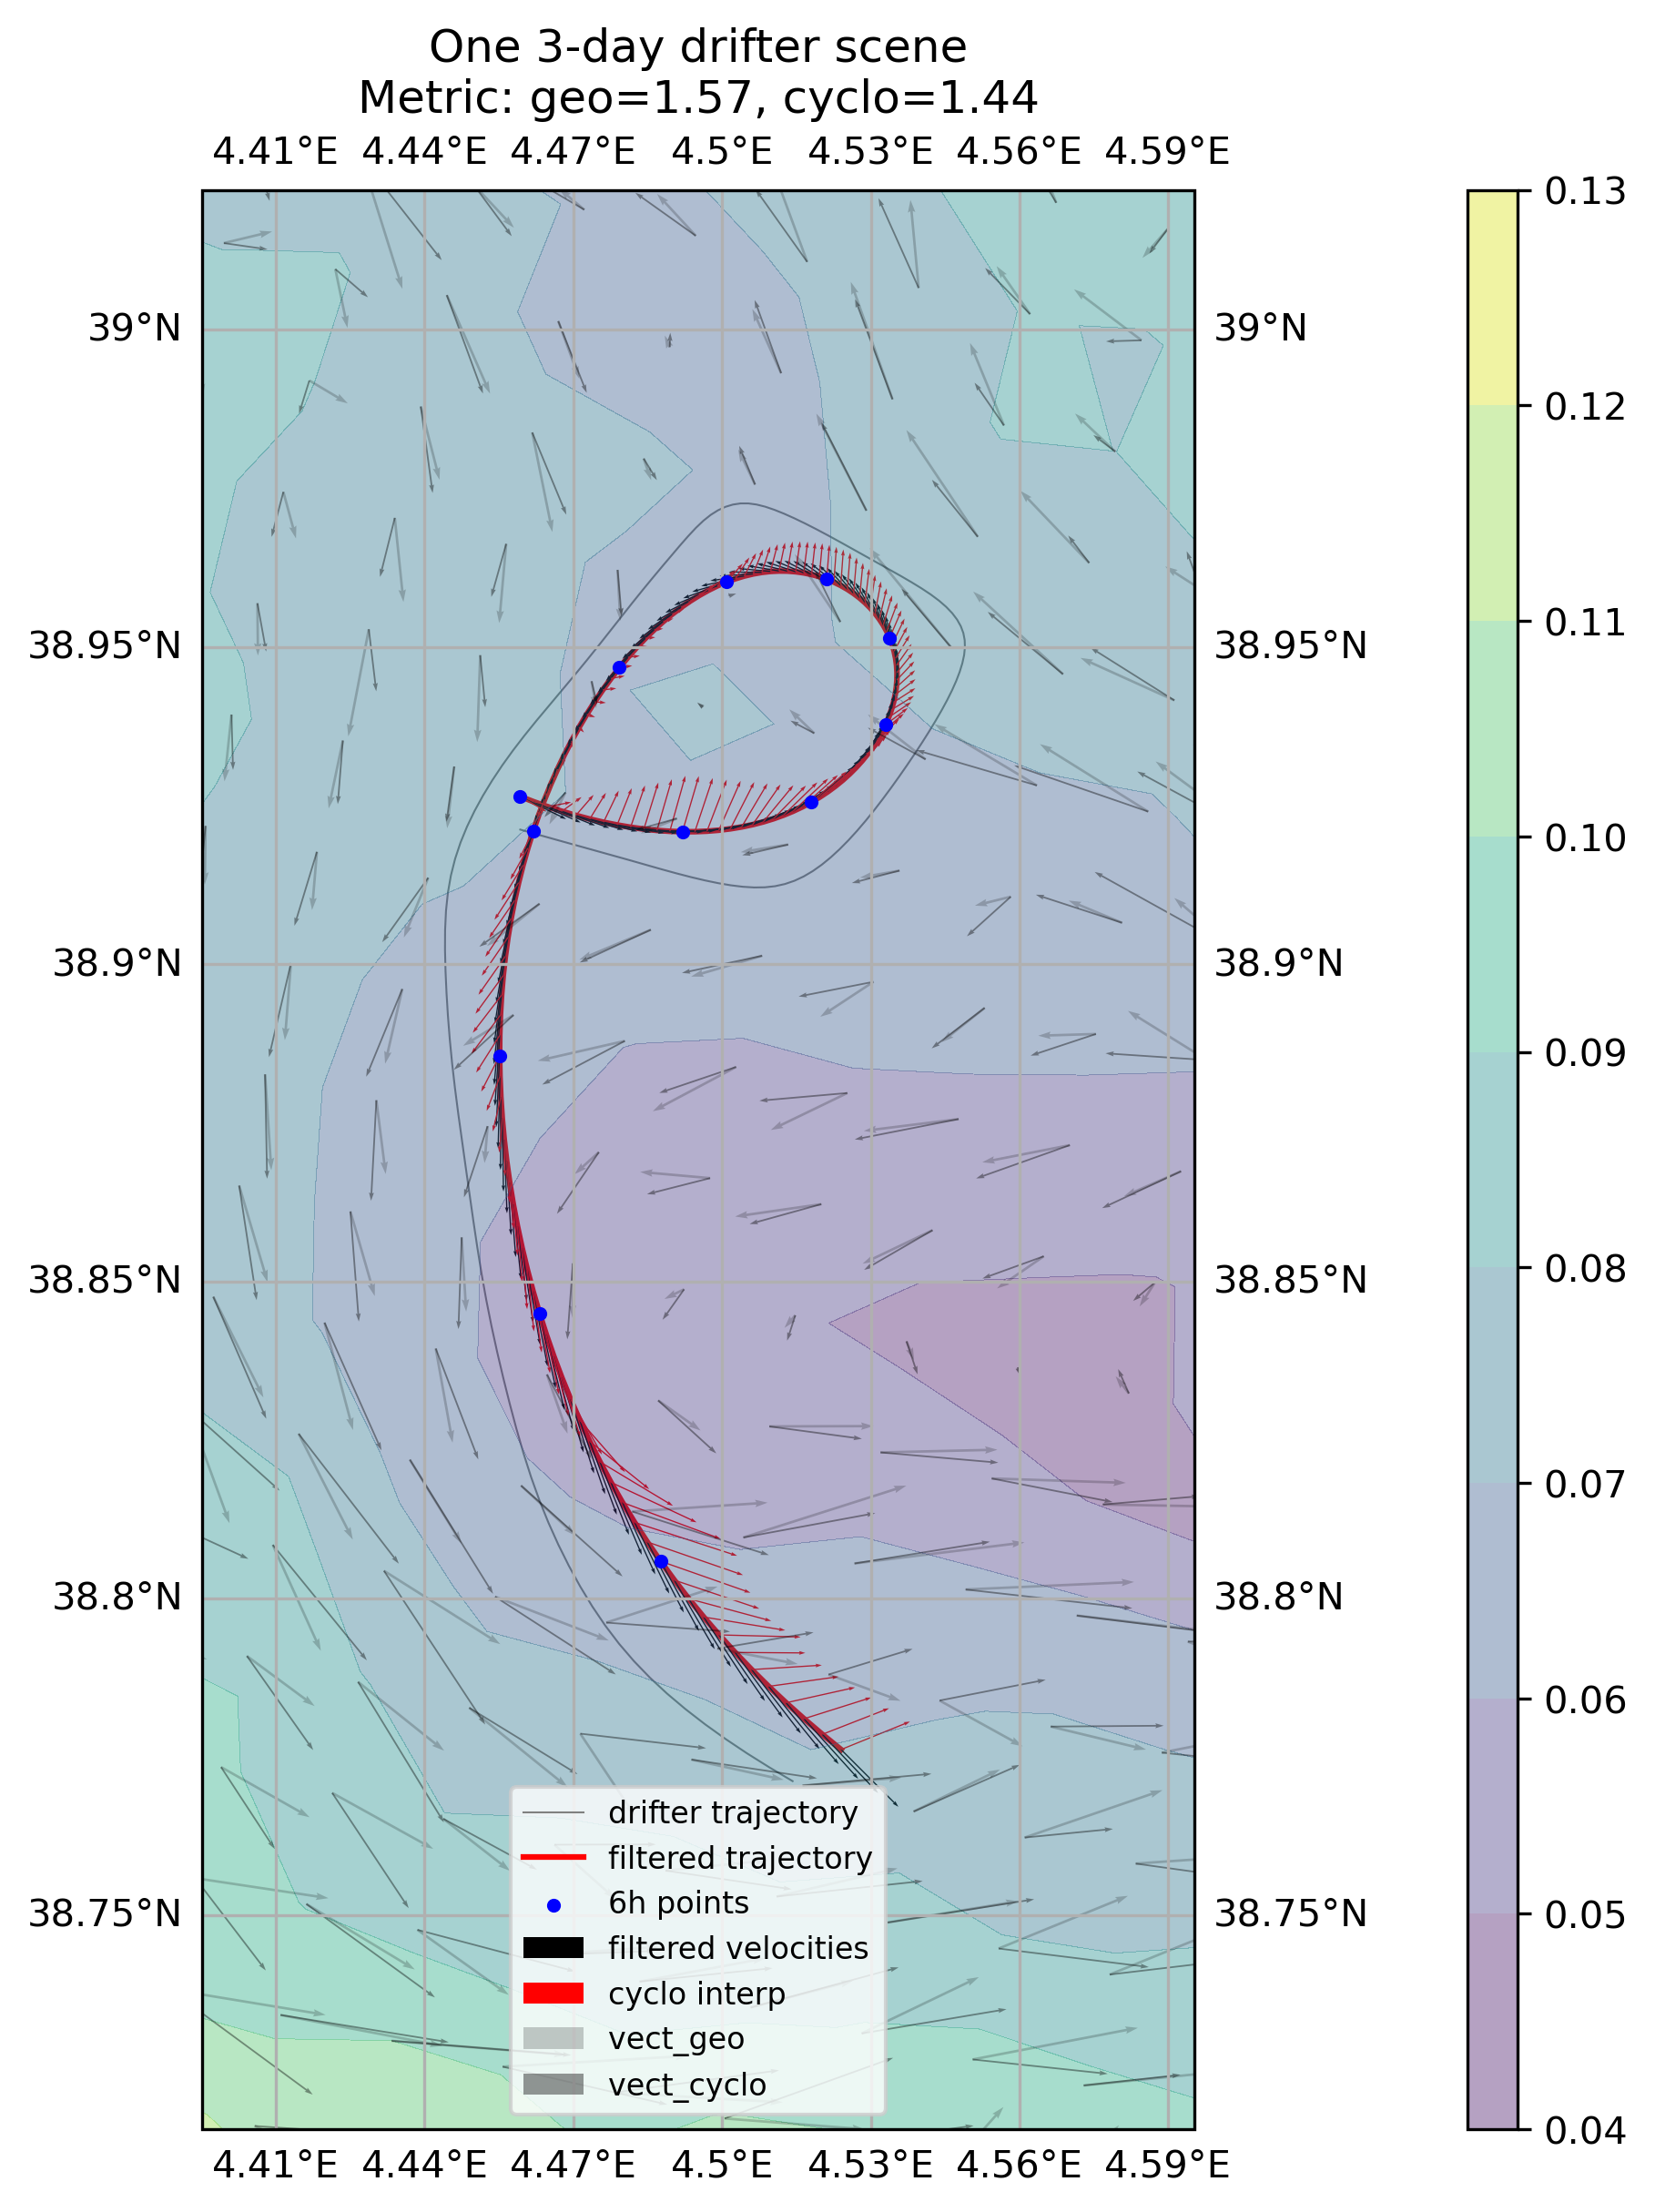

In [21]:
plot_scene(scenes.isel(scene=9), ds_swot, field_vec='both', time_ssh=10., points_hours=6, plot=True)

## Process all files

In [58]:
##################

filtering = False
NAME = 'scenes_raw'
path_save_data = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/scenes_all_test'
verbose = True

##################


for id_file in range(len(FILES_SVP)):
    ds = xr.open_dataset(os.path.join(L2_dir, FILES_SVP[id_file]))
    num_idx = ds.sizes['id']
    del ds

    for idx_id in range(num_idx):
        if verbose:
            print('processing file {:02d} id {:02d}'.format(id_file, idx_id))

        traj = open_one_traj(L2_dir, FILES_SVP[id_file], idx_id= idx_id, L3_cleaning=True, padd_swath=0.25)
        print(traj)

        if traj == np.nan :
            if verbose:
                print('traj not in swath')
            break
        
        time_span = ( traj.time.values.max() - traj.time.values.min() ) /1e9 /24 /3600
        
        if time_span > 5: #remove traj < 5 days

            traj = traj.where(isnear_swath(traj.lon, traj.lat, dlon=0.25), drop=True) # be sure to remove parts of the trajectory too far from the swath

            traj = Drifters_processing.one_trajectory_filtering_and_field_comparison(
                
                                                                                    traj=traj, 
                                                                                    field=ds_swot,
                                                                                    interp_func=interp_linear_velocity_field_L3, 
                                                                                    filtering=filtering,
                                                                                    
                                                                                    )#, low_pass_cutoff=1/(36/3600), filter_positions='gaussian', gaussian_width=10*3600)

            # keep the part of the trajectory in the swath
            traj = traj.where(isin_swath(traj.lon_filtered, traj.lat_filtered), drop=True)

            # cut into chunks-scenes
            scenes = Drifters_processing.get_scenes_from_traj(traj)

            scenes = Drifters_processing.add_metrics(scenes)
            
            # --- SAVE
            #scenes.to_netcdf(os.path.join(path_save_data, '{}_file_{}_idxid_{}.nc'.format(NAME, id_file, idx_id)))

        elif verbose:
            print('traj too small')

processing file 00 id 00
<xarray.Dataset>
Dimensions:  (time: 1242)
Coordinates:
    id       <U15 '300534061395960'
  * time     (time) datetime64[ns] 2023-05-04T20:30:00 ... 2023-05-30T17:00:00
Data variables:
    u        (time) float64 0.04412 0.04457 0.04103 ... -0.08004 -0.08155
    v        (time) float64 0.08516 0.0805 0.0887 ... -0.2575 -0.2587 -0.2666
    lon      (time) float64 4.928 4.929 4.93 4.931 ... 4.684 4.683 4.682 4.68
    lat      (time) float64 40.84 40.84 40.84 40.84 ... 40.68 40.68 40.67 40.67
Attributes:
    traj_id:  file=L2_svp_scripps_10min_lowess_30min_v0.nc ; idx_id=0
traj not in swath
processing file 01 id 00
None


AttributeError: 'NoneType' object has no attribute 'time'

In [55]:
len(FILES_SVP)

6

False